### Investigating ghost coherence

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.util import _extract_roi, create_stages_time_grid

#### Spectral analysis parameters

In [3]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
decim = 20  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper

n_freqs = 80  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)  # Frequency array
n_cycles = freqs / 4  # Number of cycles
mt_bandwidth = None


def return_evt_dt(align_at):
    """Return the window in which the data will be loaded
    depending on the alignment"""
    assert align_at in ["cue", "match"]
    if align_at == "cue":
        return [-0.65, 3.00]
    else:
        return [-2.2, 0.65]

#### Loading data

In [4]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141024",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

In [5]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

In [6]:
band = slice(26, 43)

In [7]:
w = _tf_decomp(
    data,
    data.attrs["fsample"],
    freqs,
    mode=mode,
    n_cycles=n_cycles,
    mt_bandwidth=None,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=20,
)

w = xr.DataArray(
    (w * np.conj(w)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(data.trials.values, data.roi.values, freqs, data.time.values[::decim]),
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   55.1s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.2min remaining:    2.9s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.2min finished


### Channels with large beta power

- F2 (36)
- F1 (63, 69, 73, 83, 84, 92, 95, 105)
- a3 (64, 65, 66, 106, 107)

In [8]:
channels = np.array([36, 63, 69, 73, 83, 84, 92, 95, 105, 64, 65, 66, 106, 107])
idx = [(ch in channels) for ch in data.channels_labels]

#### Trial-averaged spectogram

In [9]:
# Select ROIs
w_sel = w.isel(roi=idx)

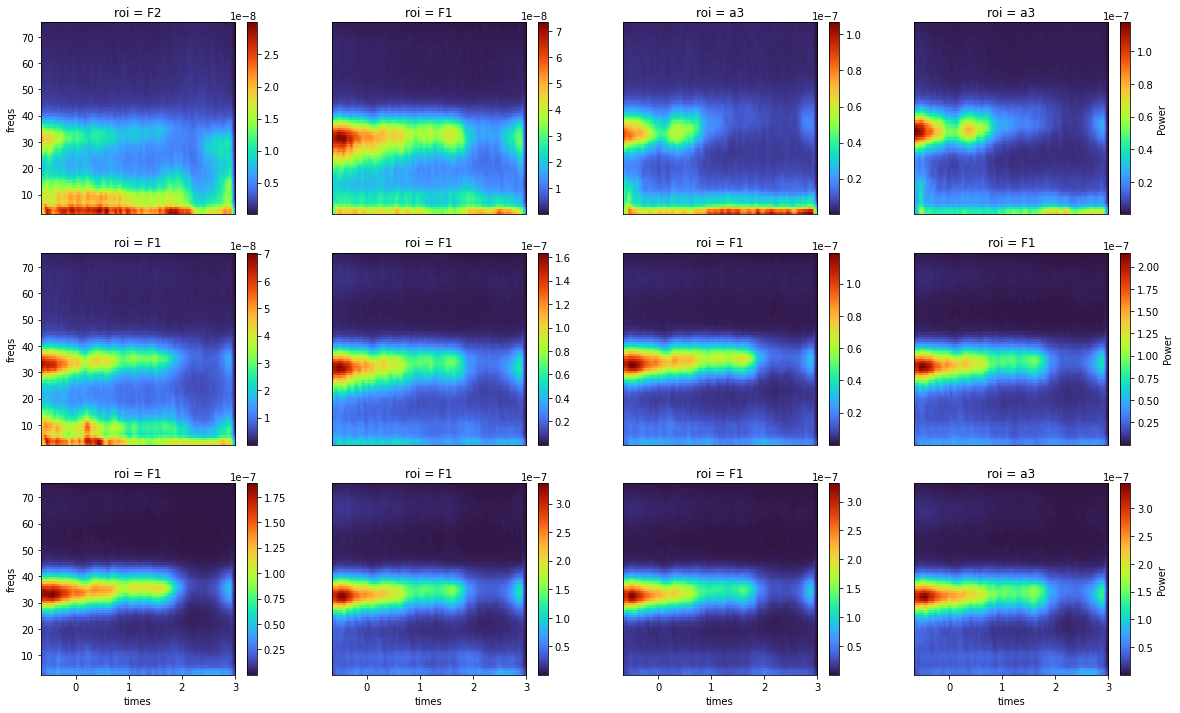

In [10]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial power

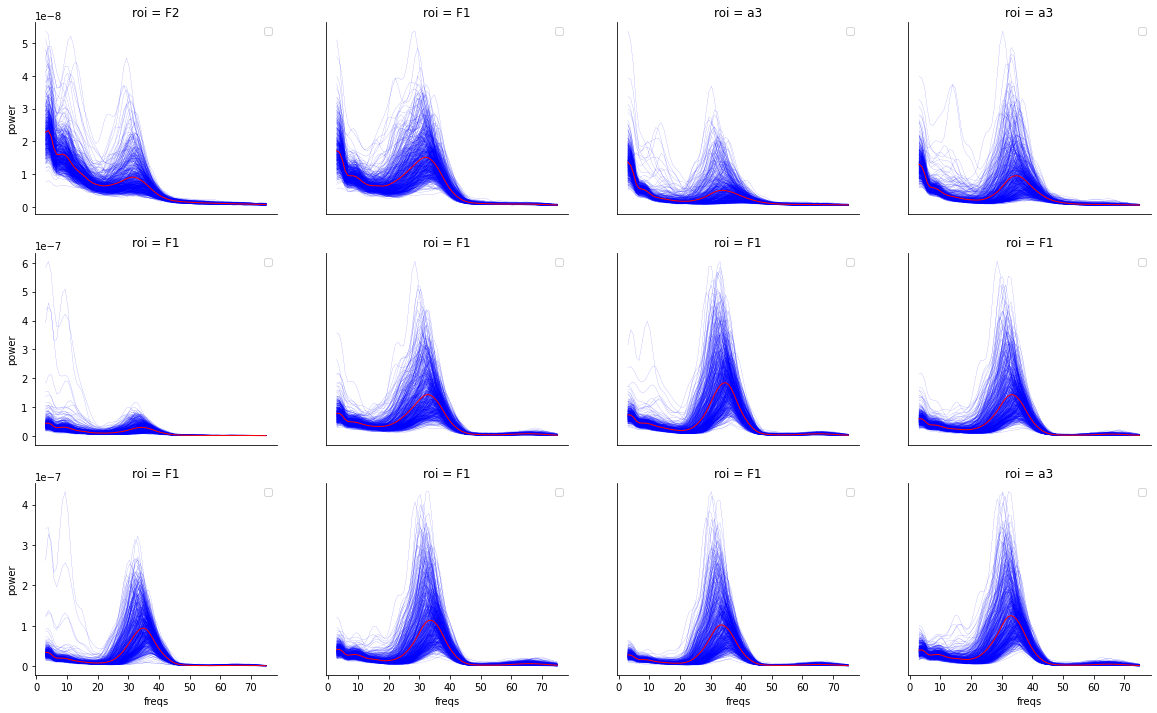

In [11]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific power time-series at single trial

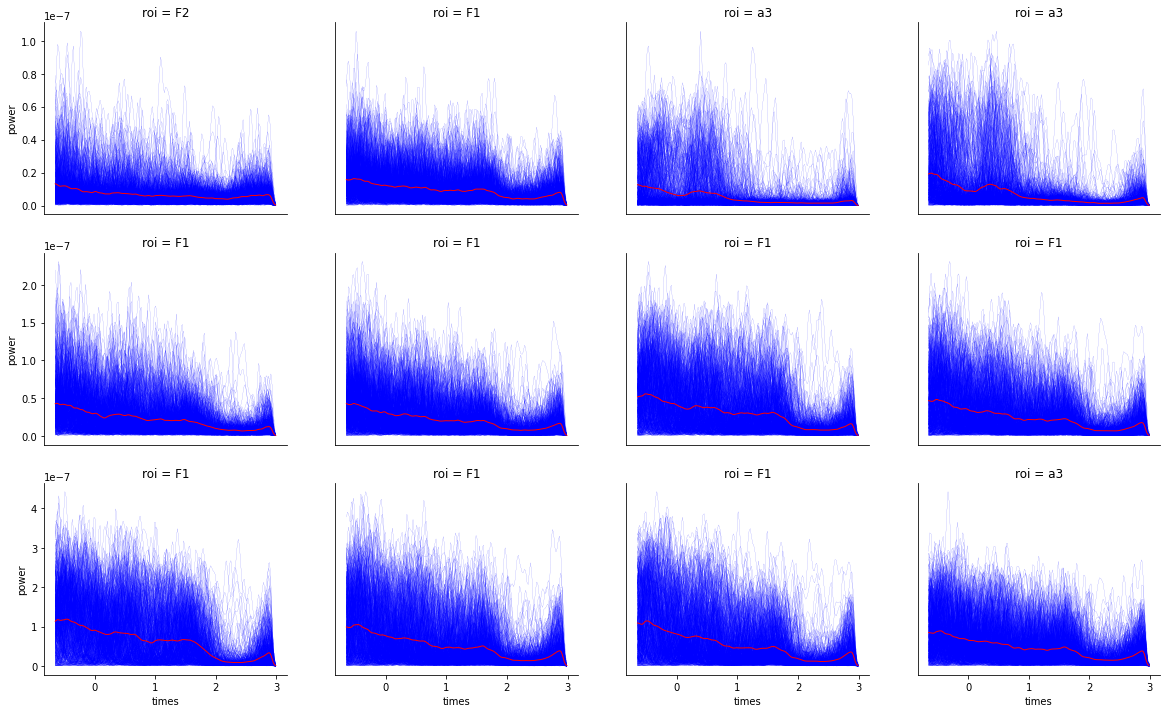

In [12]:
out = w_sel.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Ghost-coherence with V1 (236)

- 36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117

#### Trial-averaged spectogram

In [13]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
idx = [(ch in channels) for ch in data.channels_labels]

In [14]:
w_sel = w.isel(roi=idx)

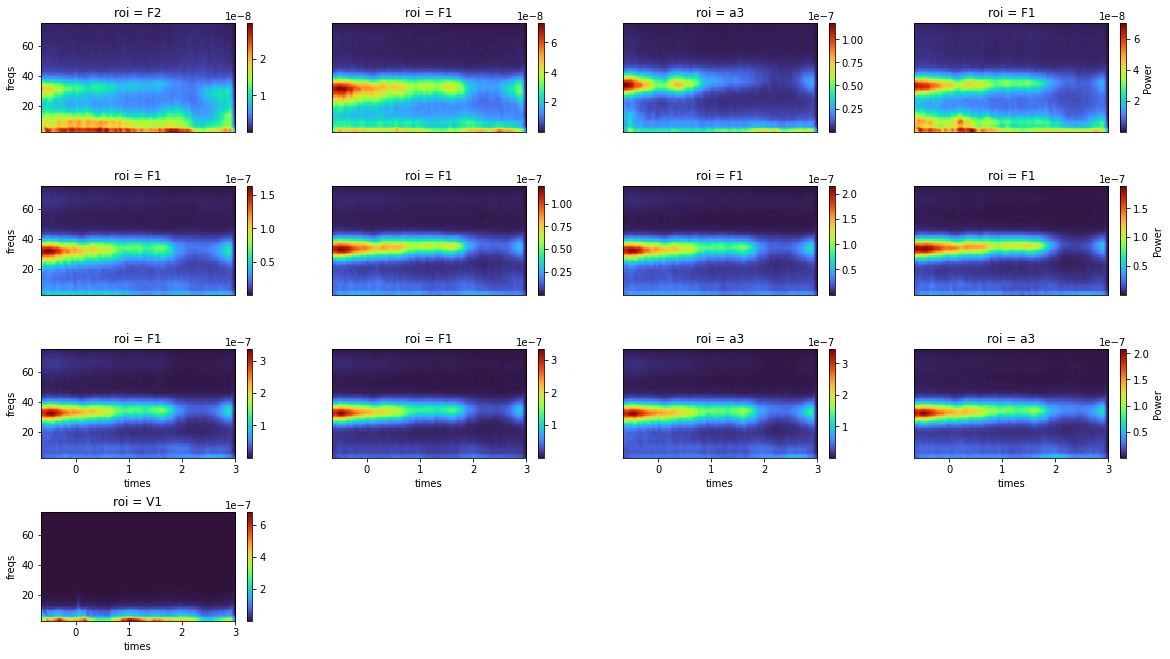

In [15]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 14))
for i in range(n_rois):
    plt.subplot(5, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
plt.subplots_adjust(hspace=0.5)

#### Time-averaged single trial power

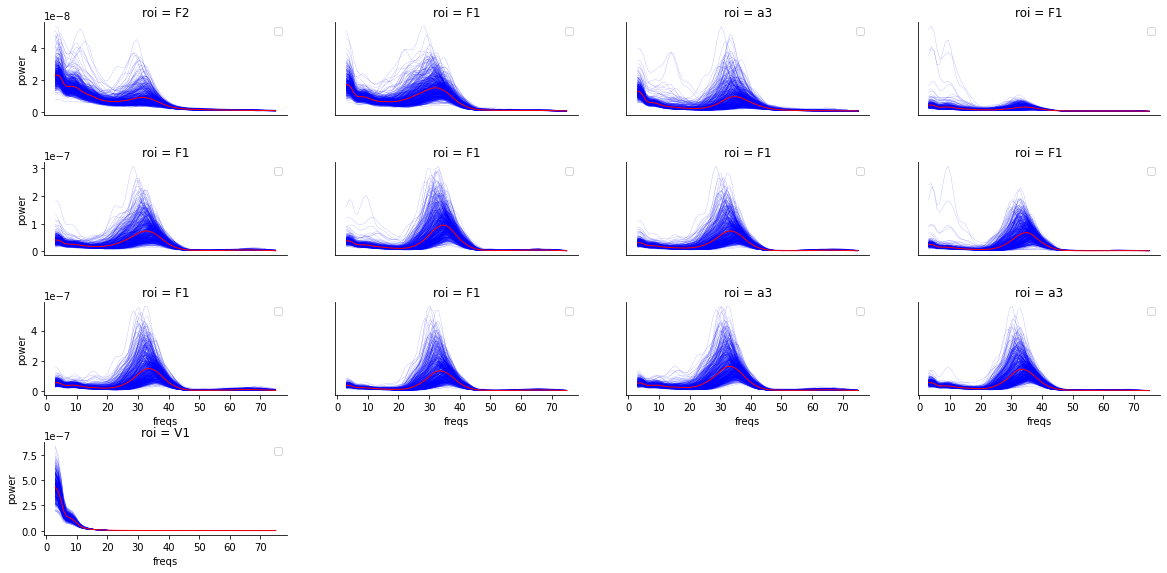

In [16]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

#### Band-specific power time-series at single trial

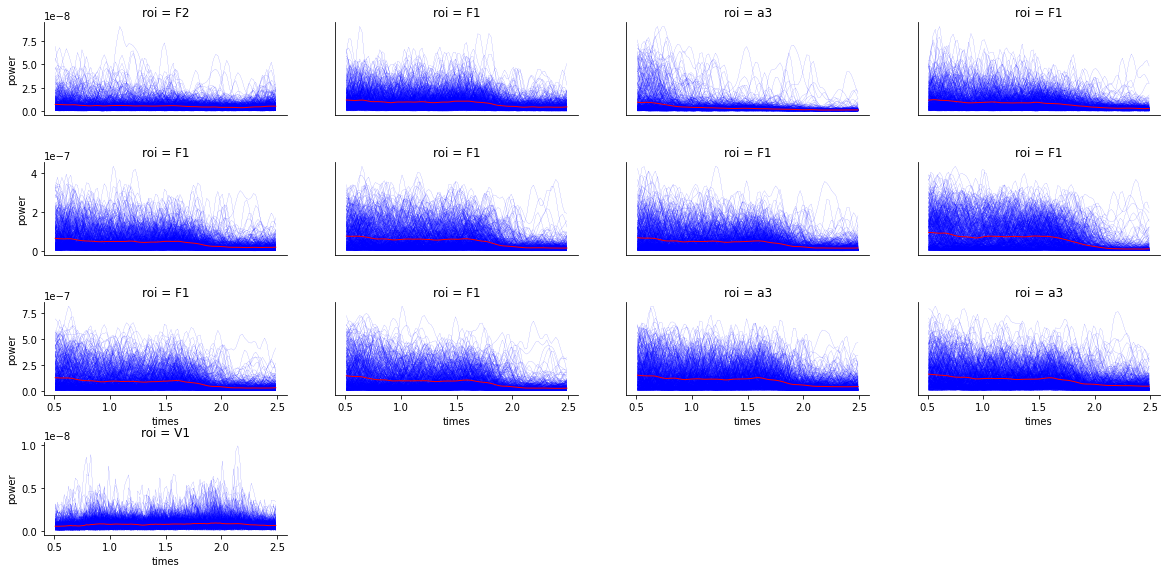

In [17]:
out = w_sel.sel(freqs=band).mean("freqs").sel(times=slice(0.5, 2.5))

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

### Computing coherence with V1 (236)

In [18]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117])
channel_v1 = np.array([236] * len(channels))

idx_s, idx_t = [], []

for ch in channels:
    if ch in data.channels_labels:
        idx_s.append(np.where(ch == data.channels_labels)[0][0])


for ch in channel_v1:
    if ch in data.channels_labels:
        idx_t.append(np.where(ch == data.channels_labels)[0][0])

In [19]:
pairs = np.vstack((idx_s, idx_t)).T

In [20]:
pairs = np.vstack((pairs, [27, 29]))

In [21]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    sfreq=ses.data.attrs["fsample"],
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    sm_kernel=sm_kernel,
    block_size=2,
)

# compute the coherence
coh = conn_spec(data, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   27.7s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   36.3s remaining:    1.5s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   37.3s finished
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/home/vinicius/anaconda3/envs/gda/lib/python3.8/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   30.4s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   39.1s remaining:    1.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   39.9s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

In [22]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, seed=123456, verbose=False)

In [23]:
# compute the coherence
coh_surr = conn_spec(data_surr, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   29.9s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   38.8s remaining:    1.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   39.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   30.8s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   40.0s remaining:    1.6s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   40.7s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

In [24]:
coh = np.clip(coh - coh_surr.quantile(0.95, "trials"), 0, np.inf)

In [25]:
coh_static = coh.sel(times=slice(-0.5, 0)).mean("times")

#### Trial-averaged time-frequency coherence

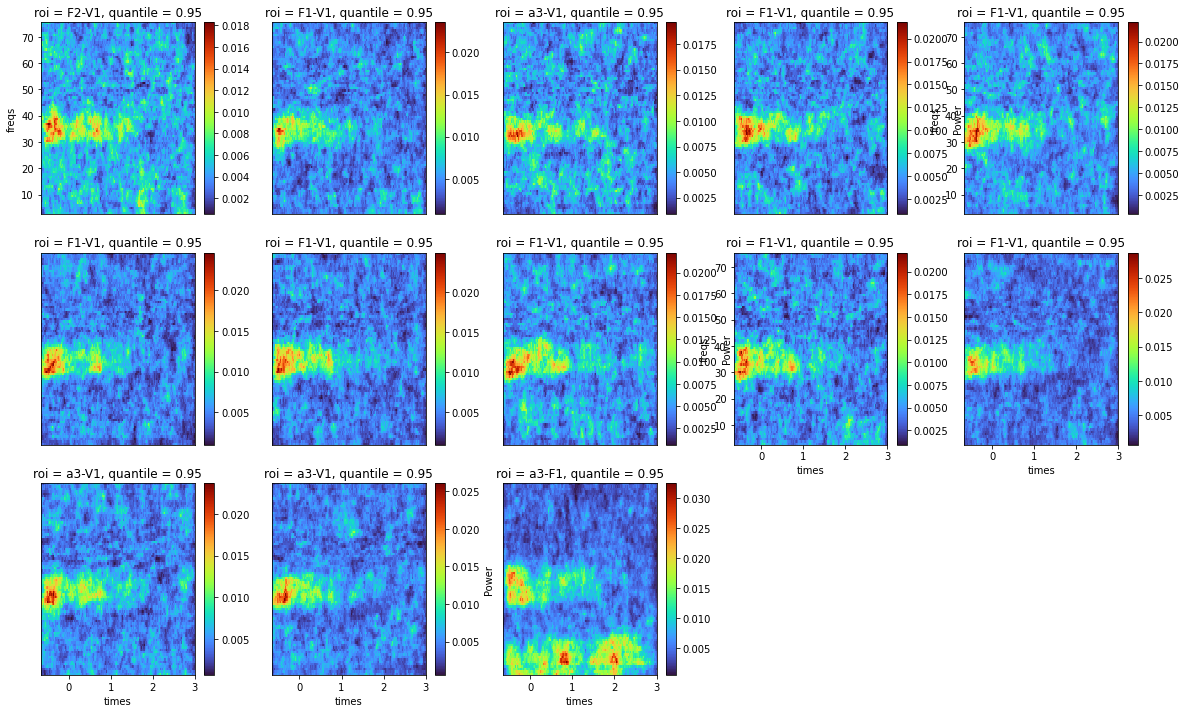

In [26]:
# Get number of ROIs
n_rois = coh.sizes["roi"]

out = coh.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 5, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial coherence

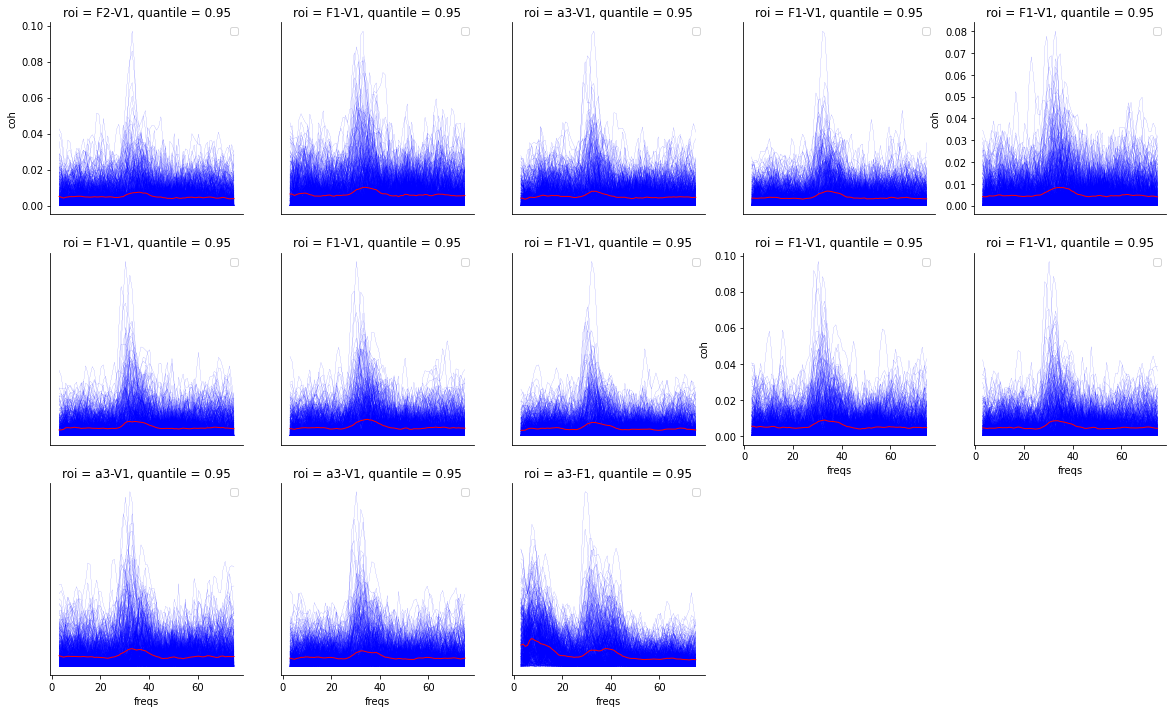

In [27]:
out = coh.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific coherence time-series at single trial

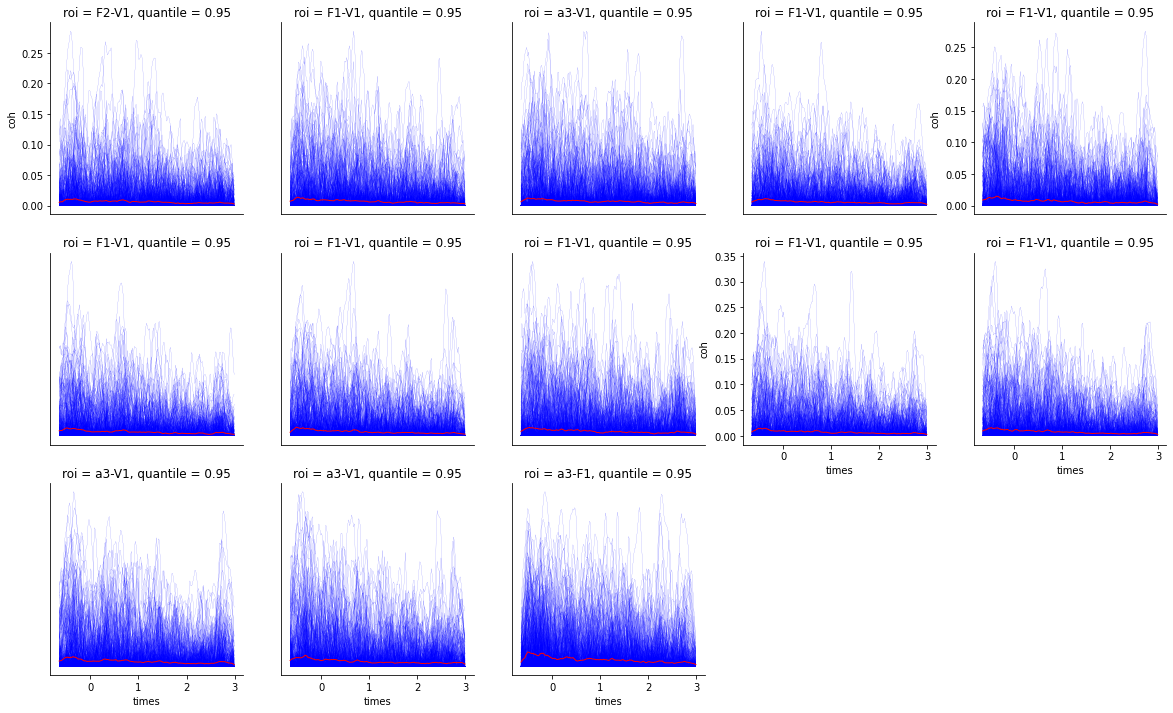

In [28]:
out = coh.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Finding peaks in the spectra and coherence

In [29]:
def detect_peaks(
    data, norm=None, kw_peaks={}, return_value=None, verbose=False, n_jobs=1
):

    assert isinstance(data, xr.DataArray)
    np.testing.assert_array_equal(data.dims, ["trials", "roi", "freqs"])

    # Names of properties in kw_peaks
    p_names = ["".join(list(key)) for key in kw_peaks.keys()]

    if norm:
        assert norm in ["max", "area"]
        if norm == "max":
            norm_values = S.max("freqs")
        else:
            norm_values = S.integrate("freqs")
        data = data / norm_values

    n_trials, n_rois = data.sizes["trials"], data.sizes["roi"]

    # Compute for each roi
    def _for_roi(i):
        peaks = np.zeros((n_trials, n_freqs))
        for t in range(n_trials):
            out, properties = find_peaks(data[t, i, :].data, **kw_peaks)
            if return_value is None:
                peaks[t, out] = 1
            else:
                peaks[t, out] = properties[return_value]
        return peaks

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_roi, n_jobs=n_jobs, verbose=verbose, total=n_rois
    )
    # Compute the single trial coherence
    peaks = parallel(p_fun(i) for i in range(n_rois))

    peaks = xr.DataArray(
        np.stack(peaks, 1), dims=data.dims, coords=data.coords, name="prominence"
    )

    return peaks

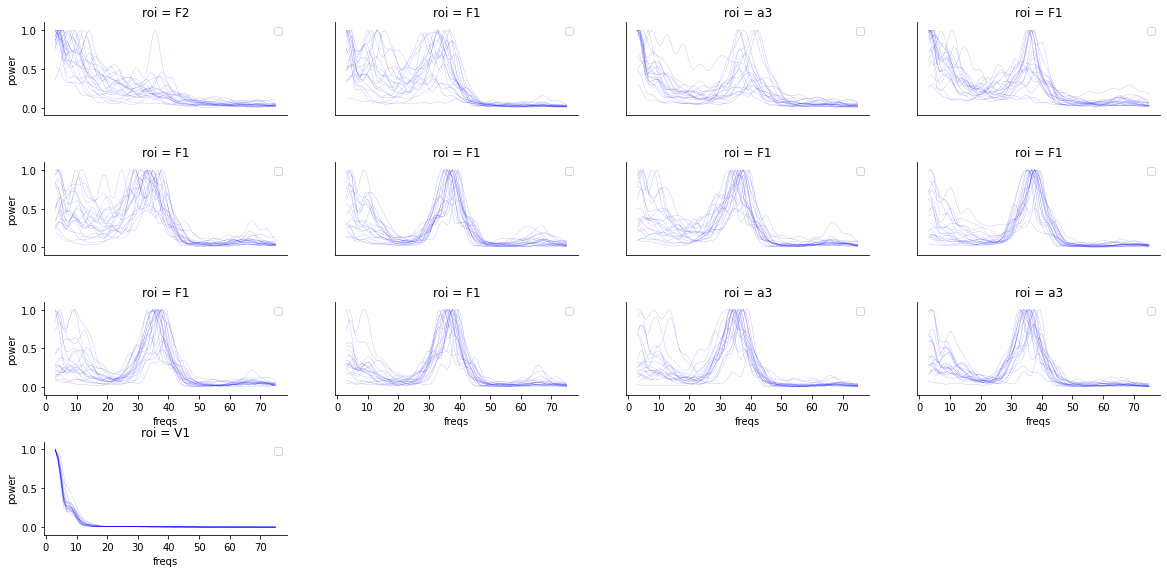

In [30]:
# Compute statical spectra
S = w_sel.sel(times=slice(-0.5, 0)).mean("times")
max_values = S.max("freqs")
S_norm = S / max_values
areas = S.roi.values

#  ROIs with channel numbers
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
rois = [f"{area} ({channel})" for area, channel in zip(S.roi.values, channels)]

peaks = S.sel(freqs=band).max("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    S_norm.isel(roi=i, trials=slice(10, 30)).plot(
        x="freqs", hue="trials", lw=0.1, c="b"
    )
    # |S_norm.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.ylim([-0.1, 1.1])
plt.subplots_adjust(hspace=0.5)

In [31]:
p = detect_peaks(S, kw_peaks=dict(height=1e-7), return_value=None, norm=None)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

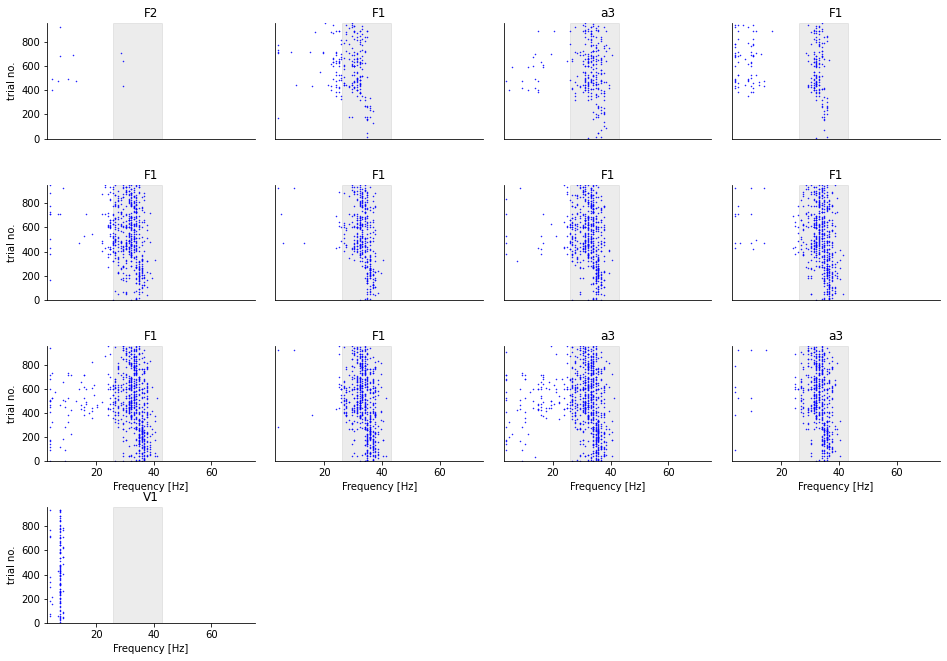

In [32]:
plt.figure(figsize=(16, 14))
for i in range(p.sizes["roi"]):
    ax = plt.subplot(5, 4, i + 1)
    for t in range(p.sizes["trials"]):
        idx = p.isel(roi=i, trials=t).values.astype(bool)
        f = p.freqs.data[idx]
        plt.plot(f, [p.trials.data[t]] * len(f), "ob", ms=0.5)
    plt.xlim(p.freqs.min(), p.freqs.max())
    plt.ylim(p.trials.min() - 1, p.trials.max() + 1)
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.title(f"{p.roi.data[i]}")
    if i < 8:
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xlabel("Frequency [Hz]")
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    else:
        plt.ylabel("trial no.")
plt.subplots_adjust(hspace=0.4, wspace=0.1)

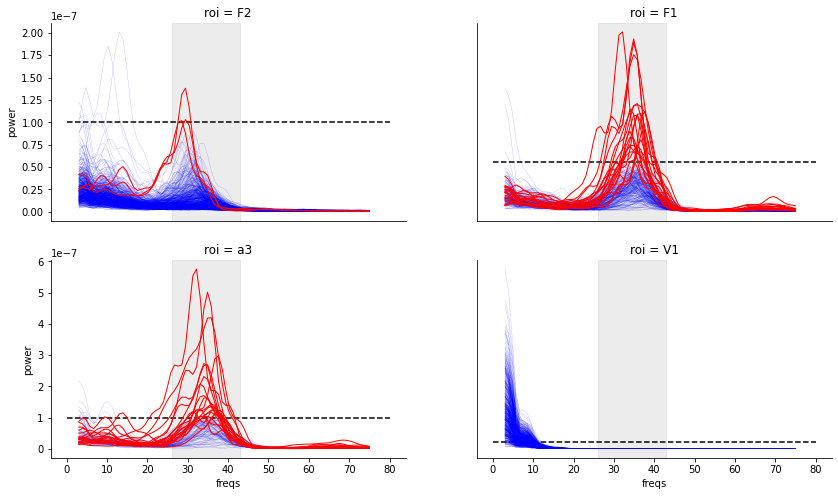

In [33]:
plt.figure(figsize=(14, 8))
for i, r in enumerate([0, 6, 10, 12]):
    ax = plt.subplot(2, 2, i + 1)

    # Index of trial that have a peak
    idx = p.isel(roi=r).sel(freqs=band).sum("freqs") > 0

    S.isel(roi=r, trials=np.logical_not(idx)).plot(
        x="freqs", hue="trials", lw=0.1, color="blue"
    )

    if np.sum(idx) > 0:
        S.isel(roi=r).isel(trials=idx).isel(trials=slice(0, 20)).plot(
            x="freqs", hue="trials", color="red", lw=1
        )

    ax.get_legend().remove()
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if i < 2:
        plt.xticks([])
        plt.xlabel("")
    if i % 2:
        plt.yticks([])
        plt.ylabel("")
    plt.hlines(1e-7, 0, coh_static.sizes["freqs"], color="black", ls="--")

In [34]:
p_coh = detect_peaks(
    coh_static, kw_peaks=dict(height=0.15), return_value=None, norm=None
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

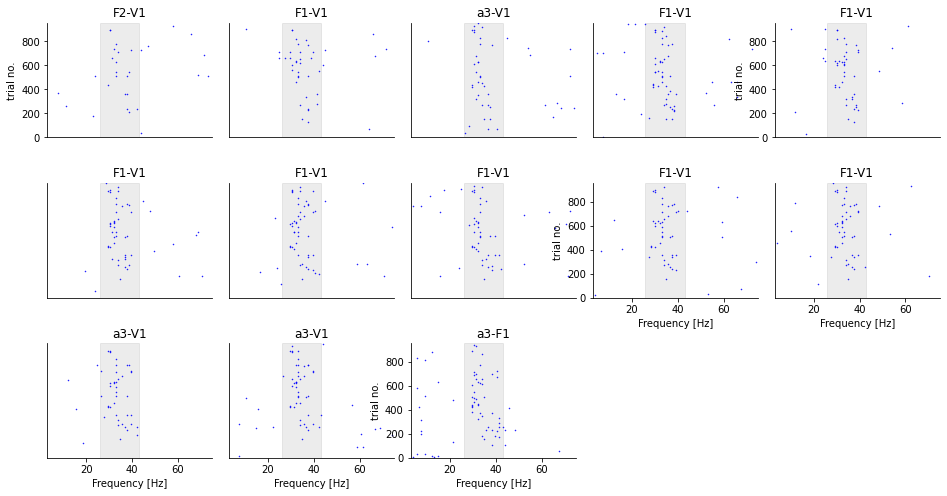

In [35]:
plt.figure(figsize=(16, 8))
for i in range(p_coh.sizes["roi"]):
    ax = plt.subplot(3, 5, i + 1)
    for t in range(p.sizes["trials"]):
        idx = p_coh.isel(roi=i, trials=t).values.astype(bool)
        f = p_coh.freqs.data[idx]
        plt.plot(f, [p_coh.trials.data[t]] * len(f), "ob", ms=0.5)
    plt.xlim(p_coh.freqs.min(), p.freqs.max())
    plt.ylim(p_coh.trials.min() - 1, p.trials.max() + 1)
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.title(f"{p_coh.roi.data[i]}")
    if i < 8:
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xlabel("Frequency [Hz]")
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    else:
        plt.ylabel("trial no.")
plt.subplots_adjust(hspace=0.4, wspace=0.1)

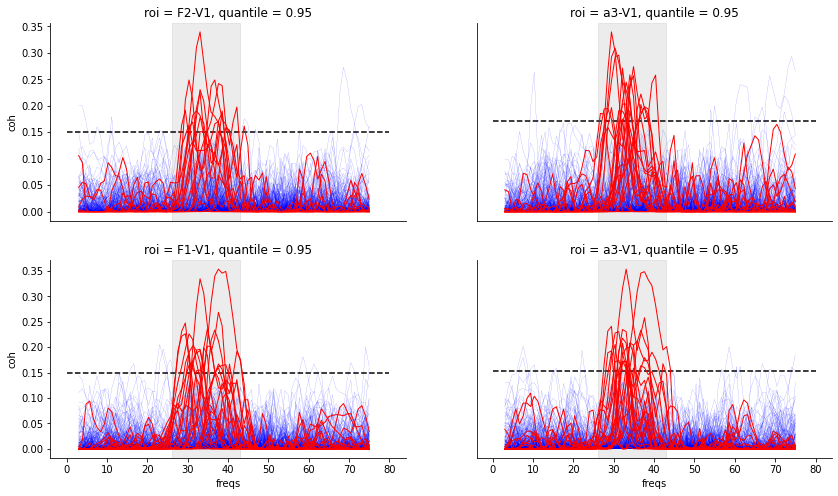

In [36]:
plt.figure(figsize=(14, 8))
for i, r in enumerate([0, 2, 6, 11]):
    ax = plt.subplot(2, 2, i + 1)

    # Index of trial that have a peak
    idx = p_coh.isel(roi=r).sel(freqs=band).sum("freqs") > 0

    coh_static.isel(roi=r, trials=np.logical_not(idx)).plot(
        x="freqs", hue="trials", lw=0.1, color="blue"
    )

    if np.sum(idx) > 0:
        coh_static.isel(roi=r).isel(trials=idx).isel(trials=slice(0, 20)).plot(
            x="freqs", hue="trials", color="red", lw=1
        )

    ax.get_legend().remove()
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if i < 2:
        plt.xticks([])
        plt.xlabel("")
    if i % 2:
        plt.yticks([])
        plt.ylabel("")
    plt.hlines(0.15, 0, coh_static.sizes["freqs"], color="black", ls="--")

|           | Power i | Power j | Coh ij |     Outcome    |
|:---------:|:-------:|:-------:|:------:|:--------------:|
| Has peak? |    T    |    T    |    T   |  True positive |
|           |    T    |    T    |    F   | False negative |
|           |    T    |    F    |    F   |  True negative |
|           |    F    |    T    |    T   | False positive |
|           |    F    |    F    |    T   | False positive |
|           |    F    |    F    |    F   |  True negative |

#### Checking for channel F2 and V1

In [269]:
bands = np.array([[0, 6], [6, 14], [14, 26], [26, 43], [43, 80]])

p_band = []
p_coh_band = []
for flow, fhigh in bands:
    p_band += [(p.sel(freqs=slice(flow, fhigh)).sum("freqs") > 0).astype(int)]
    p_coh_band += [(p_coh.sel(freqs=slice(flow, fhigh)).sum("freqs") > 0).astype(int)]

p_band = xr.concat(p_band, "freqs")
p_coh_band = xr.concat(p_coh_band, "freqs")

In [270]:
O1 = p_coh_band.isel(roi=6) * (
    p_band.isel(roi=6) + p_band.isel(roi=-1)
) + p_coh_band.isel(roi=6)
# O1 = O1.isel(trials=O1.sum("freqs") > 0)

O2 = p_coh_band.isel(roi=-1) * (
    p_band.isel(roi=1) + p_band.isel(roi=2)
) + p_coh_band.isel(roi=-1)
# O2 = O2.isel(trials=O2.sum("freqs") > 0)

Text(531.1090909090908, 0.5, '')

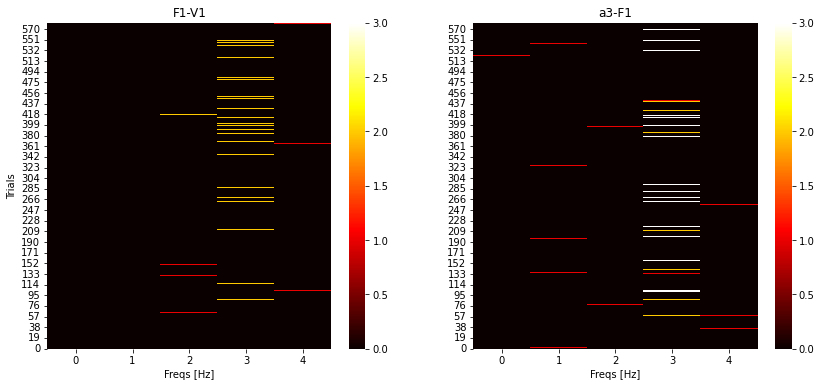

In [271]:
plt.figure(figsize=(14, 6))

ax = plt.subplot(1, 2, 1)
sns.heatmap(data=O1.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O1.roi.data}")
plt.yticks(rotation=0)
plt.xlabel("Freqs [Hz]")
plt.ylabel("Trials")

ax = plt.subplot(1, 2, 2)
sns.heatmap(data=O2.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O2.roi.data}")
plt.yticks(rotation=0)
plt.xlabel("Freqs [Hz]")
plt.ylabel("Trials")
plt.ylabel("")

In [329]:
# Get channels with False Positive I type
t_fp1 = np.arange(O1.sizes["trials"], dtype=int)[O1.isel(freqs=3) == 1]
# Get channels with False Positive II type
t_fp2 = np.arange(O1.sizes["trials"], dtype=int)[O1.isel(freqs=3) == 2]

Text(0.5, 1.0, '')

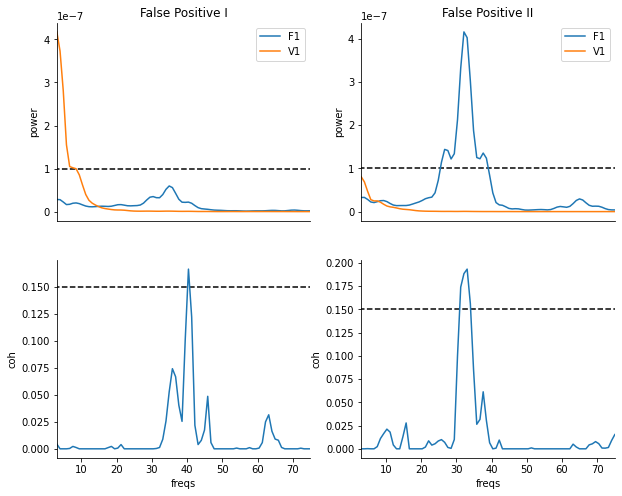

In [331]:
plt.figure(figsize=(10, 8))

# Sample a trial with FPI
i_fp1 = np.random.choice(t_fp1)
# Sample a trial with FPII
i_fp2 = np.random.choice(t_fp2)

ax = plt.subplot(2, 2, 1)
S.isel(trials=i_fp1).isel(roi=6).plot()
S.isel(trials=i_fp1).isel(roi=-1).plot()
plt.legend(
    [
        f"{S.isel(trials=i_fp1).isel(roi=6).roi.data}",
        f"{S.isel(trials=i_fp1).isel(roi=-1).roi.data}",
    ]
)
plt.hlines(1e-7, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks([])
plt.xlabel("")
plt.title("False Positive I")

ax = plt.subplot(2, 2, 3)
coh_static.isel(trials=i_fp1).isel(roi=6).plot()
plt.hlines(0.15, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("")

ax = plt.subplot(2, 2, 2)
S.isel(trials=i_fp2).isel(roi=6).plot()
S.isel(trials=i_fp2).isel(roi=-1).plot()
plt.legend(
    [
        f"{S.isel(trials=i_fp2).isel(roi=6).roi.data}",
        f"{S.isel(trials=i_fp2).isel(roi=-1).roi.data}",
    ]
)
plt.hlines(1e-7, 0, 75, "k", ls="--")
plt.xlim([3, 75])
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("False Positive II")

ax = plt.subplot(2, 2, 4)
coh_static.isel(trials=i_fp2).isel(roi=6).plot()
plt.hlines(0.15, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("")

In [332]:
# Get channels with False Positive I type
t_fp1 = np.arange(O2.sizes["trials"], dtype=int)[O2.isel(freqs=3) == 1]
# Get channels with False Positive II type
t_fp2 = np.arange(O2.sizes["trials"], dtype=int)[O2.isel(freqs=3) == 2]

Text(0.5, 1.0, '')

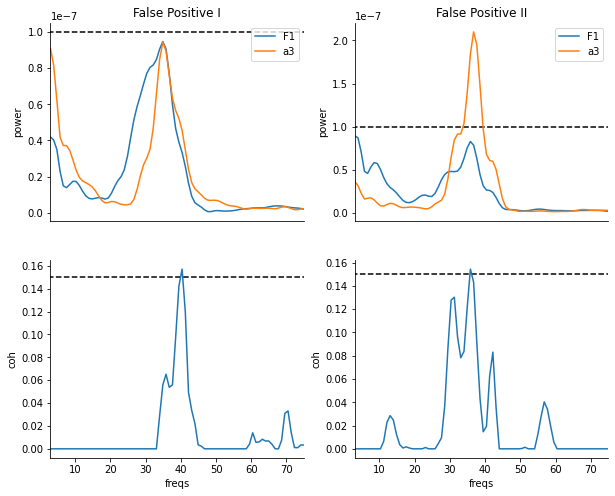

In [336]:
plt.figure(figsize=(10, 8))

# Sample a trial with FPI
i_fp1 = np.random.choice(t_fp1)
# Sample a trial with FPII
i_fp2 = np.random.choice(t_fp2)

ax = plt.subplot(2, 2, 1)
S.isel(trials=i_fp1).isel(roi=1).plot()
S.isel(trials=i_fp1).isel(roi=2).plot()
plt.legend(
    [
        f"{S.isel(trials=i_fp1).isel(roi=1).roi.data}",
        f"{S.isel(trials=i_fp1).isel(roi=2).roi.data}",
    ]
)
plt.hlines(1e-7, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks([])
plt.xlabel("")
plt.title("False Positive I")

ax = plt.subplot(2, 2, 3)
coh_static.isel(trials=i_fp1).isel(roi=-1).plot()
plt.hlines(0.15, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("")

ax = plt.subplot(2, 2, 2)
S.isel(trials=i_fp2).isel(roi=1).plot()
S.isel(trials=i_fp2).isel(roi=2).plot()
plt.legend(
    [
        f"{S.isel(trials=i_fp2).isel(roi=1).roi.data}",
        f"{S.isel(trials=i_fp2).isel(roi=2).roi.data}",
    ]
)
plt.hlines(1e-7, 0, 75, "k", ls="--")
plt.xlim([3, 75])
plt.xticks([])
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("False Positive II")

ax = plt.subplot(2, 2, 4)
coh_static.isel(trials=i_fp2).isel(roi=-1).plot()
plt.hlines(0.15, 0, 75, "k", ls="--")
plt.xlim([3, 75])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.title("")

### Overlap of beta and gamma bands

In [41]:
beta = slice(26, 43)
gamma = slice(43, 80)

In [42]:
rois = [
    f"{area} ({channel})" for area, channel in zip(w.roi.values, data.channels_labels)
]

In [43]:
w_beta = w.sel(freqs=beta).mean("freqs")
w_gamma = w.sel(freqs=gamma).mean("freqs")

In [44]:
z_beta = (w_beta - w_beta.mean("times")) / w_beta.std("times")
z_gamma = (w_gamma - w_gamma.mean("times")) / w_gamma.std("times")

In [45]:
cc = (z_beta * z_gamma).mean("times")
cc = cc.assign_coords({"roi": rois})

In [46]:
df = cc.to_dataframe(name="cc").reset_index()
df = df.sort_values("cc", ascending=False)

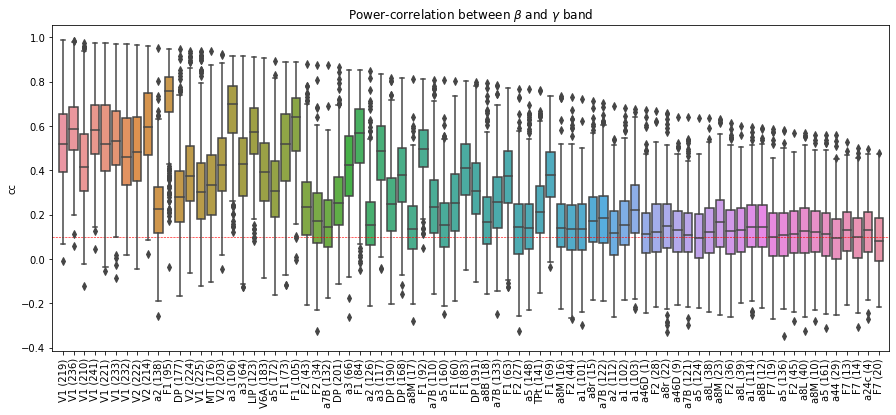

In [47]:
plt.figure(figsize=(15, 6))

sns.boxplot(x=df["roi"], y=df["cc"])
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, cc.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, cc.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band");

In [48]:
z_beta = (w_beta - w_beta.mean("times")) / w_beta.std("times")
z_gamma = (w_gamma - w_gamma.mean("times")) / w_gamma.std("times")

trials_shuffle = z_gamma.trials.data

CC = []

for i in tqdm(range(500)):

    np.random.shuffle(trials_shuffle)

    x1 = z_beta.sel(trials=trials_shuffle)

    np.random.shuffle(trials_shuffle)

    x2 = z_gamma.sel(trials=trials_shuffle)

    cc_surr = (x1 * x2).mean("times")
    cc_surr = cc_surr.assign_coords({"roi": rois})

    CC += [cc_surr]

100%|██████████████████████████| 500/500 [01:01<00:00,  8.19it/s]


In [49]:
thr = xr.concat(CC, dim="surr").quantile(0.95, "surr")
thr = thr.to_dataframe("thr").reset_index()

In [50]:
mean = thr.groupby(["roi"]).mean("thr")
std = thr.groupby(["roi"])["thr"].std()

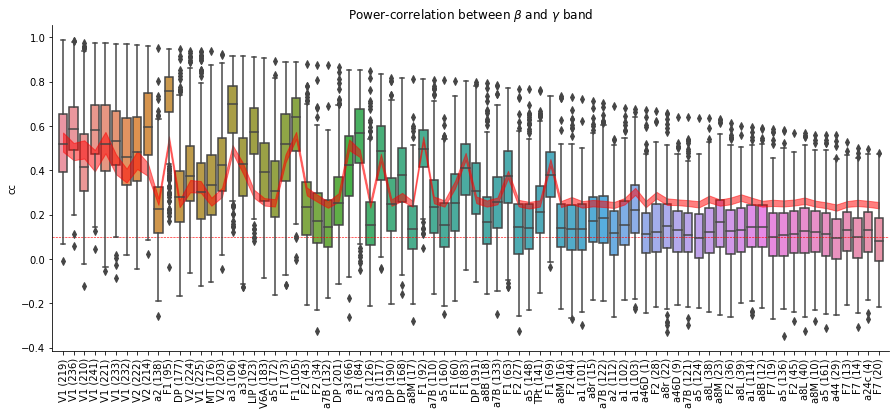

In [51]:
plt.figure(figsize=(15, 6))

ax = sns.boxplot(x=df["roi"], y=df["cc"])

rois = [t.get_text() for t in ax.get_xticklabels()]

mean = mean.reindex(index=rois).thr.values
std = std.reindex(index=rois).reset_index().thr.values

plt.fill_between(
    range(cc.sizes["roi"]),
    mean - std,
    mean + std,
    alpha=0.5,
    color="red",
)
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, cc.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, cc.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band");

#### Channels above chance level

In [52]:
z_beta = z_beta.assign_coords({"roi": cc.roi.data})
z_gamma = z_gamma.assign_coords({"roi": cc.roi.data})

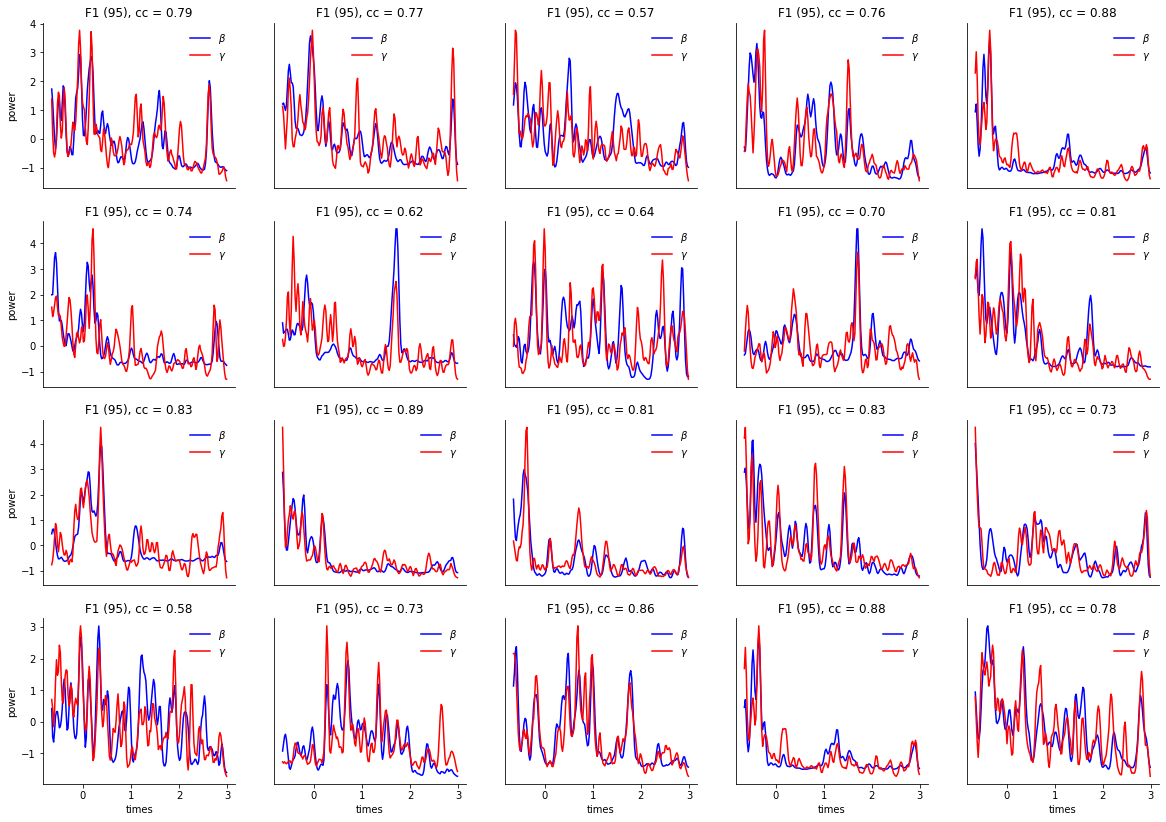

In [53]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F1 (95)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

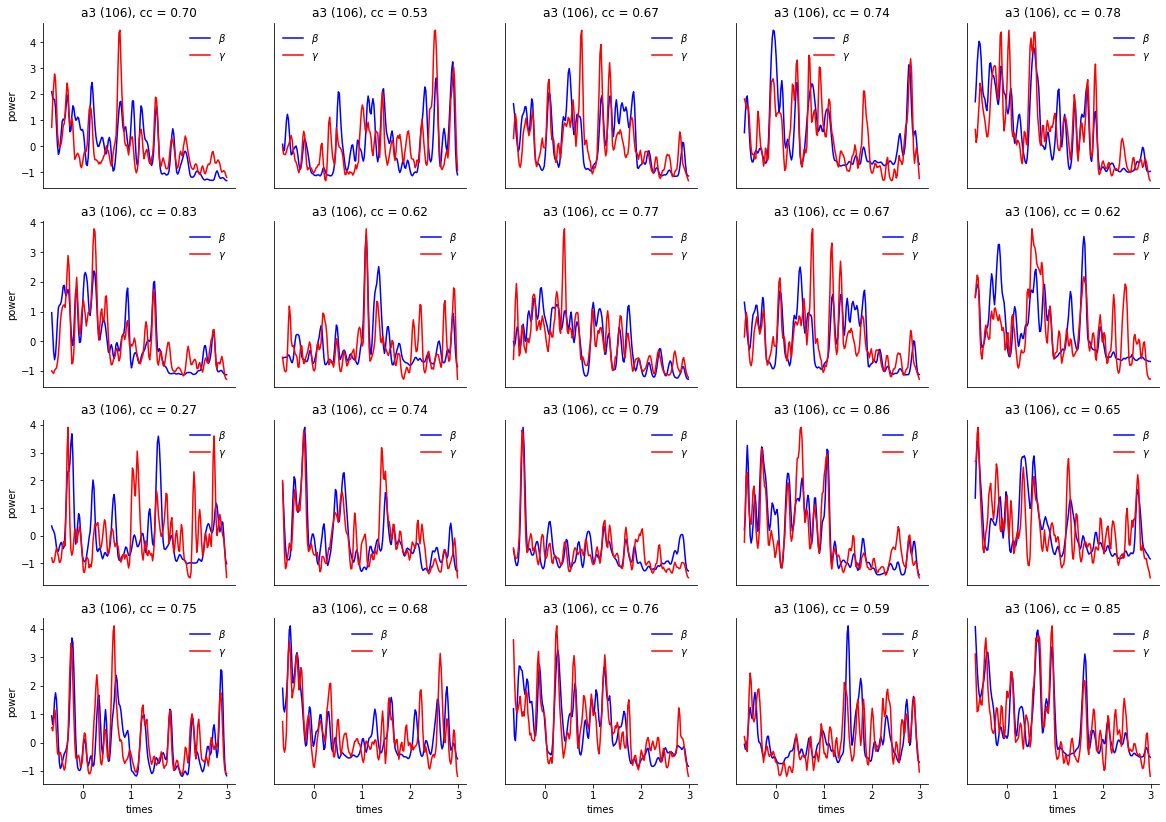

In [54]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "a3 (106)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

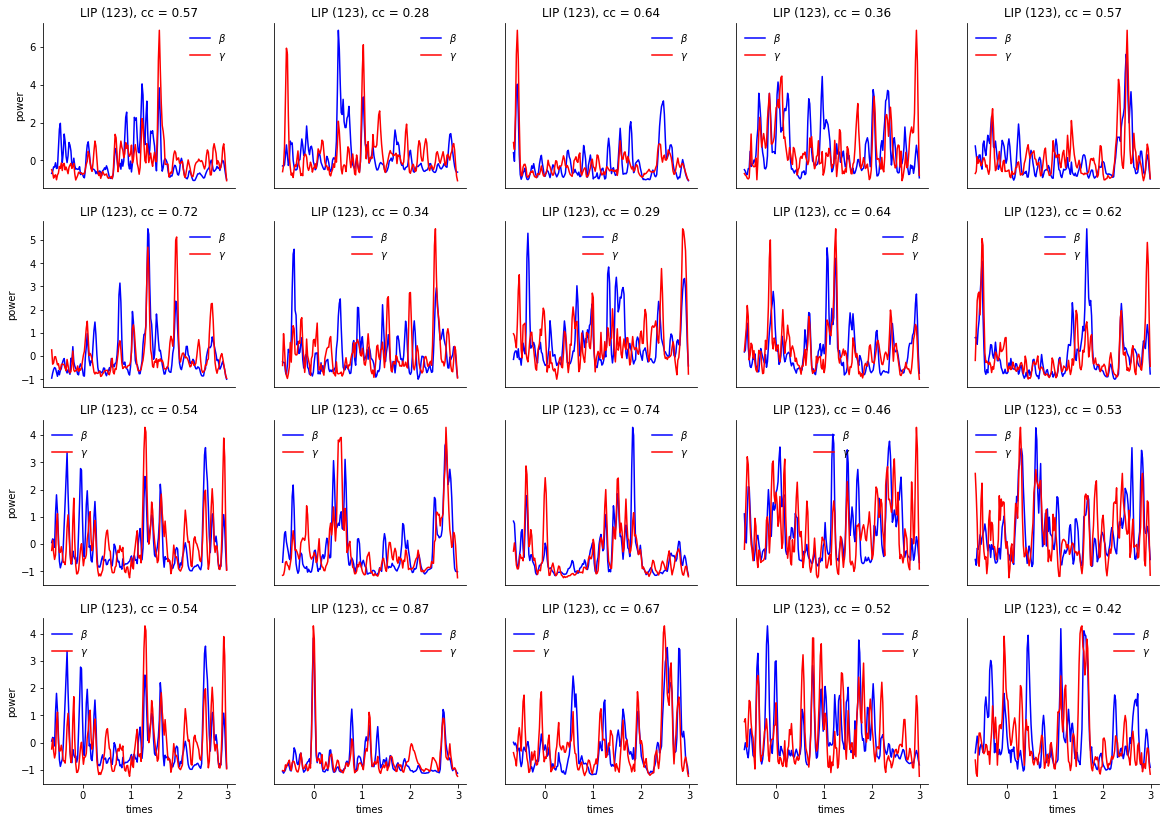

In [55]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "LIP (123)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

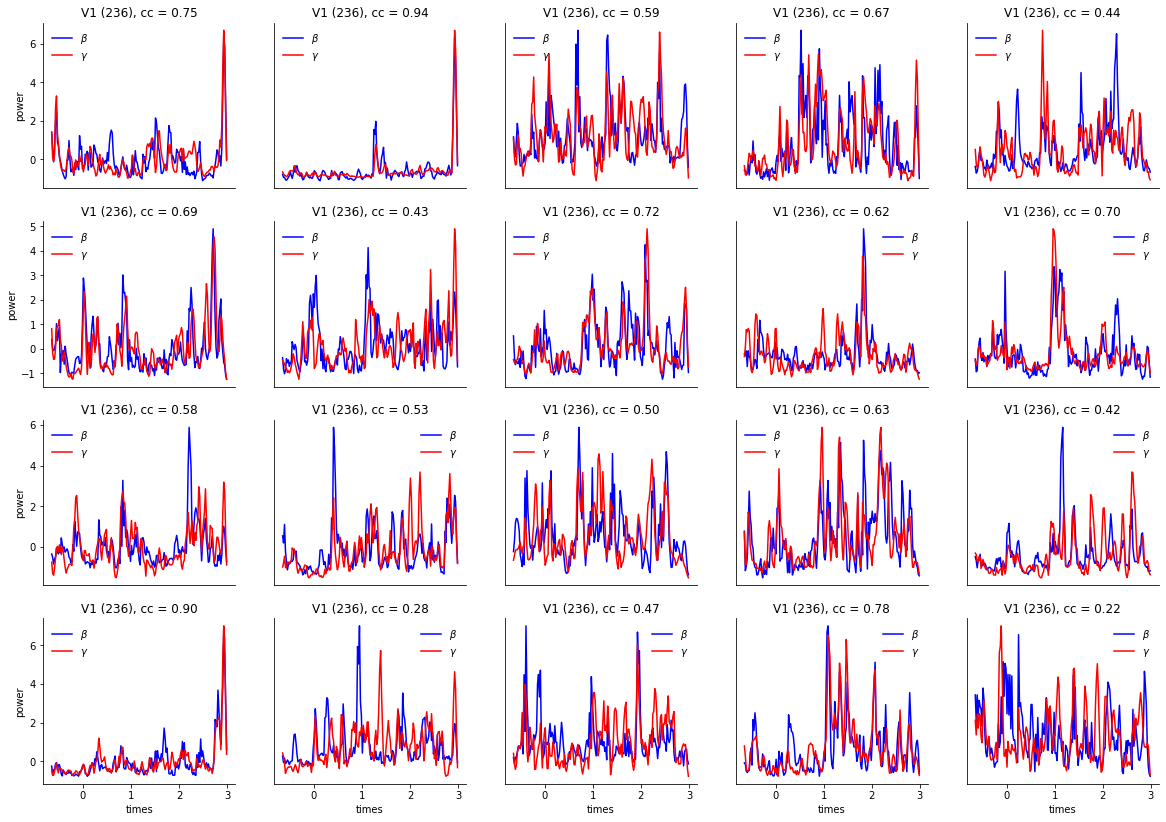

In [56]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "V1 (236)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

#### Channels bellow chance level

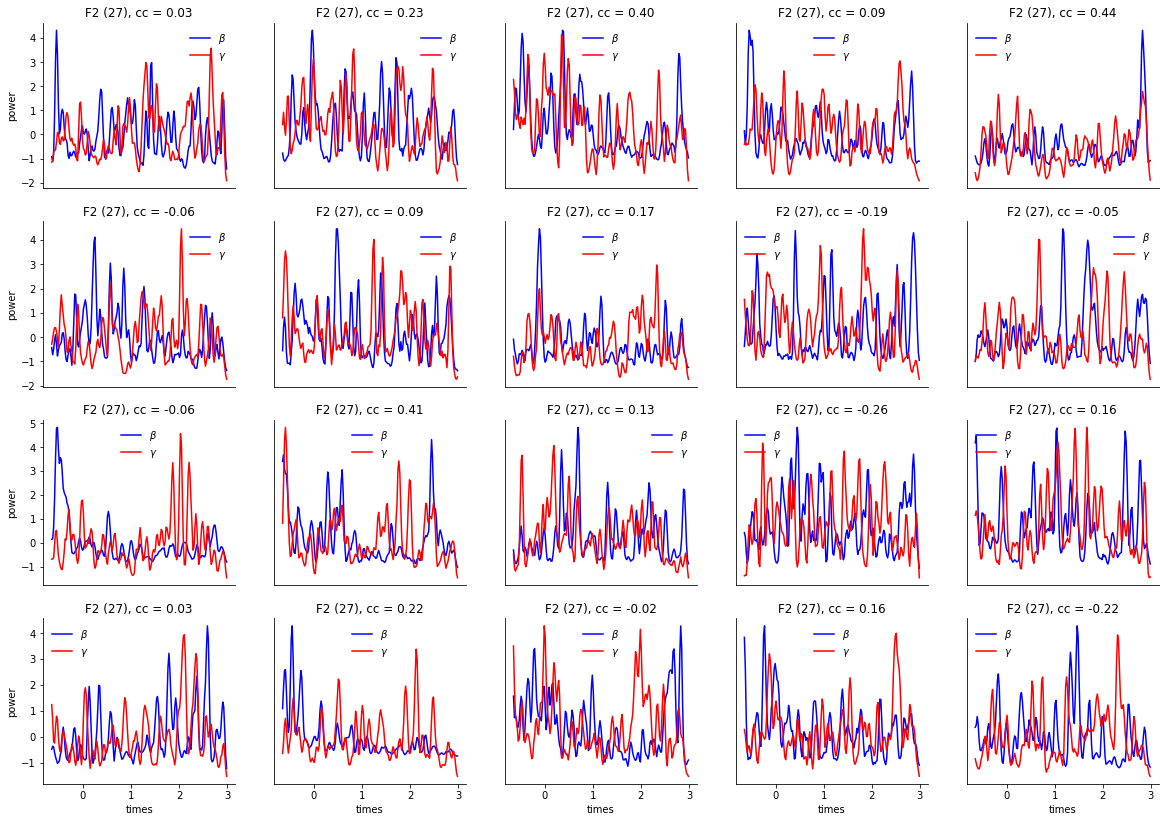

In [57]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F2 (27)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

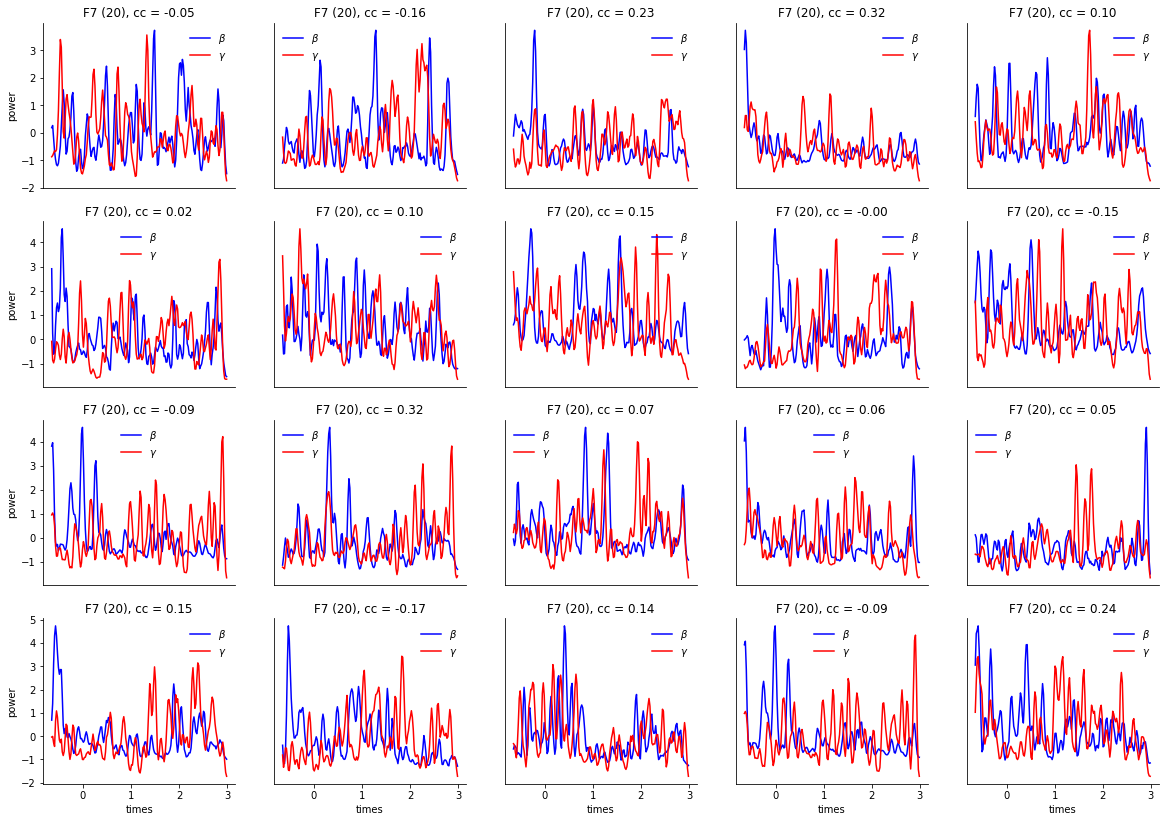

In [58]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F7 (20)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

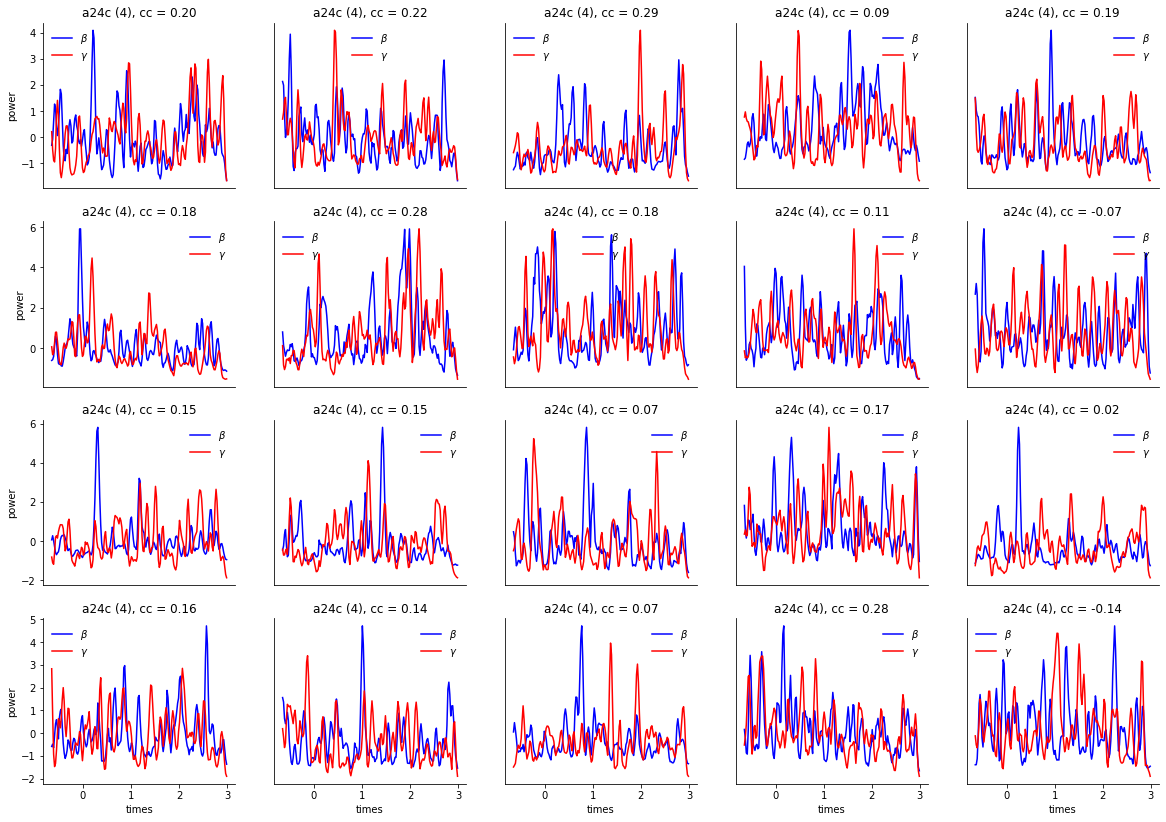

In [59]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "a24c (4)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

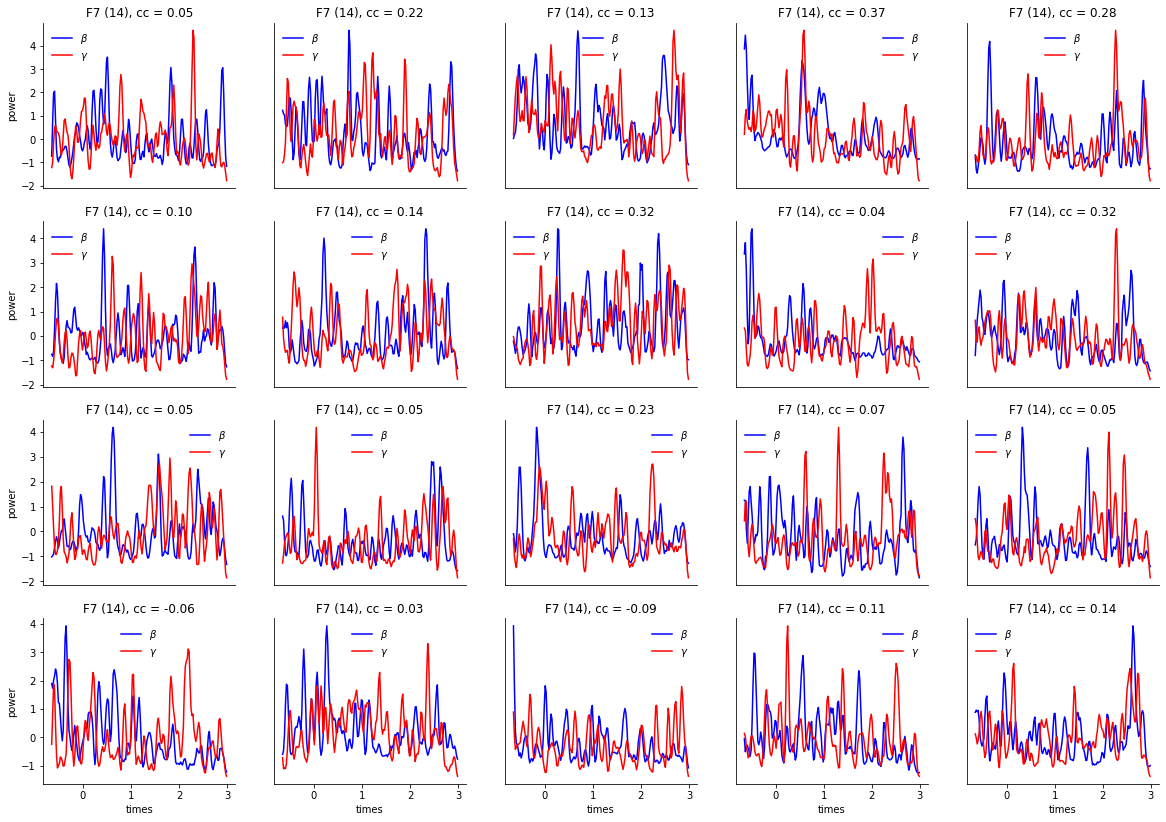

In [60]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F7 (14)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])